## Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning. We will use the dimensionality reduction and clustering techniques presented this morning to analyze both toy examples and real images.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`). 

First let's load the functions we will use

In [1]:
import numpy as np
import numpy.matlib
import math
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm

from skimage.io import imread
from skimage.transform import resize
from skimage.transform import rescale
from skimage import img_as_bool

from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.spatial.distance import dice
from skimage.measure import find_contours

from scipy.io import loadmat

# I - Dimensionnality reduction: NMF

## I - 1) Dataset

You will first work on the same face images as during the practical work 1.

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

**Goal**

The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 

Let's load the data and define a function to plot the faces. If you do not remember how the dataset is constituted, please refer to the previous practical work.

In [2]:
import os
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  dest_path='./YaleB_32x32.mat')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory=os.getcwd().replace('\\','/')




x = loadmat(Working_directory + './YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')




Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest=Xtest-np.mean(Xtest,axis=0) # centering
Xctrain=Xtrain-np.mean(Xtrain,axis=0) # centering



def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=math.ceil(len(indeces)/ncol)
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data
There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


## I - 2) NNMF

Here you will test Non-negative Matrix factorization. The basis images of the training are in the matrix $W_{train}$ and the scores (or coefficients) to test the performance in $H_{train}$. The test scores are computed as $H_{test}=W_{train}^{-1}X_{test}$.

**Question**

1. Use the scikit-learn implementation to test the performance.
2. Plot the basis images and compare them with respect to the basis images obtained using PCA and ICA in the last practical work. What can you say ?
3. What about the performances of NNMF, i.e. computational time and classification accuracy ? Is it better or worse than the other methods ? Why ?
4. Do you think that it is a good idea to use a PCA before the NMF algorithm? Why?

**Answers**

2. The new base vectors provide a more accurate representation of facial features compared to PCA and ICA. As a result, it becomes simpler to observe and analyze the defining characteristics of the data.
3. Although NNMF takes longer to compute than PCA and KPCA because of the gradient descent algorithm used, it yields superior outcomes.
4. NMF produces easily interpretable base vectors, but this is only feasible when using a real image as the foundation. If PCA is applied beforehand, the interpretability is lost, rendering it an unfavorable option.

NNMF uses  100  features
Percentage of correct answer using NNMF is  0.8737060041407867


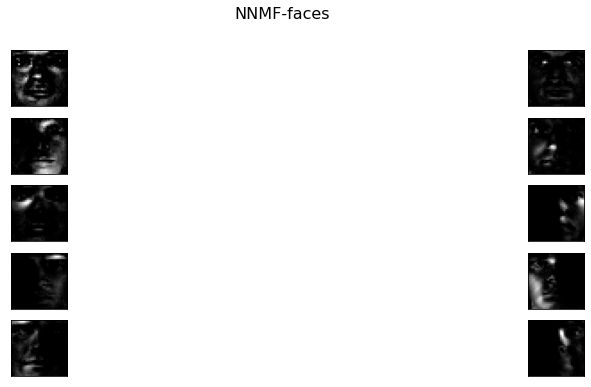

In [3]:
# NNMF (scikit-learn implementation)
Ncomponents=100
model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
WtrainNNMF = model.fit_transform(Xtrain.T)
HtrainNNMF = model.components_

plotFaces(WtrainNNMF.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces') 

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(WtrainNNMF),Xtest.T)

print('NNMF uses ', Ncomponents, ' features')

# Score
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(HtrainNNMF.T,Id_Train.ravel())
print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))

Implement your own implementation in `NNMFLecture` following the lecture slides. Complete the missing lines (`XXXXXXXXXX`) 

In [4]:
def NNMFLecture(X,r=None,N_Iter=1000,tolerance=1e-3,plot_evolution=1):
    '''
    Inputs: 
    %           X: is a [dxN] matrix. Every column (x) is an observation and every
    %           row consists of features.
    %
    %           r: size of the matrices W and H
    %
    %           (Optional) N_Iter: maximum number of iterations
    %
    %           (Optional) tolerance: convergence criteria threshold
    %
    %           (Optional) plot_evolution: plot evolution convergence criteria
    %
    % Outputs:
    %           W: is a [d x r] matrix containing the basis images in its
    %           columns
    %           
    %           H: is a [r x N] matrix containing the loadings (h) in its columns
    %           of the linear combination: x=Wh 
    %
  '''
    if r is None:
        r=X.shape[0]
        
    # Test for positive values
    if np.min(X) < 0:
        raise NameError('Input matrix X has negative values !')      

    # Size
    d,N=X.shape
   
    # Initialization
    W = np.ones((d, r))
    H = np.random.rand(r, N)   
    
    # parameters for convergence
    k = 0
    delta = np.inf
    eps=np.finfo(float).eps
    evolutionDelta=[]
 
    while delta > tolerance and k < N_Iter:
        
        # multiplicative method      
        
        XH=np.dot(X,H.T)
        HH=np.dot(H,H.T)
        for i in range(20):
            W = np.divide(W * XH, W @ HH + eps)
                       
        H = np.divide(H * (W.T @ X), W.T @ W @H + eps)

        # Convergence indices
        k = k + 1           
        diff=X-np.dot(W,H)     
        #delta = np.sqrt(np.sum(diff**2)) / np.sqrt(np.sum(X**2)) # |X-WH|_2 / |X|_2
        delta = LA.norm(diff,'fro') / LA.norm(X,'fro') # sqrt(trace(diff'*diff)) / sqrt(trace(X'*X))
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration NNMF number ', k, ' out of ', N_Iter , ', delta = ', delta, ', error (norm delta): ', LA.norm(diff))
     
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')
    
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - NNMF')
        plt.show()
    
    return W,H

Iteration NNMF number  1  out of  300 , delta =  0.5303397179654198 , error (norm delta):  272.9960172360579
Iteration NNMF number  100  out of  300 , delta =  0.1581335869652442 , error (norm delta):  81.4003514546846
Iteration NNMF number  200  out of  300 , delta =  0.1505969764834323 , error (norm delta):  77.52082937610564
Iteration NNMF number  300  out of  300 , delta =  0.14804209127673804 , error (norm delta):  76.20568464472738
Maximum number of iterations reached ! delta =  0.14804209127673804


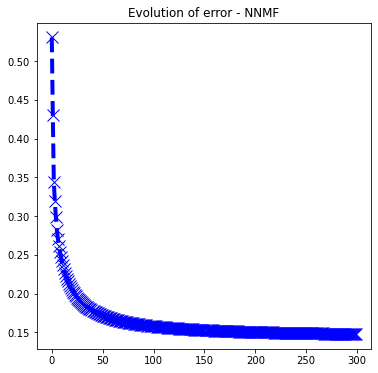

NNMF uses  100  features
Percentage of correct answer using NNMF is  0.8633540372670807


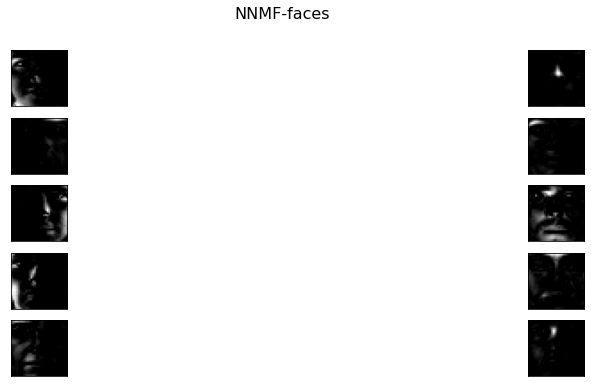

In [5]:
# NNMF (your own implementation)
Ncomponents=100
Wtrain_nnmf,Htrain_nnmf = NNMFLecture(Xtrain.T,r=Ncomponents,N_Iter=300,tolerance=1e-3,plot_evolution=1)
plotFaces(Wtrain_nnmf.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces') 

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(Wtrain_nnmf), Xtest.T)

print('NNMF uses ', Ncomponents, ' features')

# Score
NN.fit(Htrain_nnmf.T,Id_Train.ravel())
print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))

- What do you observe?
- What is the limitation of doing an inversion for Htest_nnmf? How would you avoid that?

**Answers**

* Based on the results of the code, we observe that the accuracy of the NNMF method we implemented is comparable to the accuracy of the one provided by the scikit-learn package. This suggests that our implementation of NNMF is valid and can be used as an alternative to the scikit-learn implementation.
* The limitation of doing an inversion for `Htest_nnmf` is that it may not be possible to invert the matrix `Wtrain_nnmf`. This can happen if the matrix `Wtrain_nnmf` is not full rank, which can occur if the number of features (`Ncomponents`) is too large compared to the number of training samples. To avoid this issue, one possible solution is to use a regularization technique, such as L1 or L2 regularization, which can help to ensure that the matrix `Wtrain_nnmf` is full rank. Another solution is to use a dimensionality reduction technique, such as PCA, to reduce the dimensionality of the feature space before applying NNMF. This can help to ensure that the number of features is not too large relative to the number of training samples, which can reduce the risk of the matrix `Wtrain_nnmf` being not full rank.

## I-3) ICA and NNMF in the presence of noise

We will now compare ICA and NNMF results in the presence of noise within the dataset. Please note that during the class on ICA, the dataset $X$ was assumed to be noiseless: we were looking for a decomposition such that $X = AS$, and not $X = AS + N$, where $N$ would be a noise term.

1. How do you think that ICA might behave in the presence of noise? You might in particular consider the case of a Gaussian noise N.
2. On the other hand, do you think that NNMF behaves better? If so, for what kind of noises?

In the following, we will try to compare the behavior of ICA and NNMF in the presence of noise. Do the following:
- add some Gaussian noise to both the training and the testing dataset.
- apply both NNMF and ICA (the second architecture you implemented in the previous practical work) on the noisy dataset. For both, you can use 250 features.
- use the NN algorithm to classify the images from the features extracted from ICA and NNMF.

Redo the same for different noise levels. Plot a curve of the classification accuracy when either ICA or NNMF are used as pre-processing steps. Comment your results.

**Answers**

1. When there is additional Gaussian noise, the performance of ICA degrades significantly due to the consistently low negentropy of the estimated sources.
2. On the other hand, NNMF will still perform better than ICA to some extent in the presence of additive noise. However, if the noise becomes too significant, as it is added in each iteration in the update of W and H, the final result quickly deteriorates. For multiplicative noise, we will obtain the same result up to a factor that corresponds to the noise.

**Comments of results**

The observation made is consistent with what was explained previously, namely that if the level of noise becomes too high, the performance of the algorithms decreases rapidly, especially the NNMF algorithm. This is likely due to the fact that the noise affects the quality of the extracted features, leading to a loss of discriminative power in the classification task. It is therefore important to carefully choose the level of noise in the data, or to apply denoising techniques prior to using ICA or NNMF.

In [6]:
sigmaTab = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5])
scoreNMF = np.zeros(len(sigmaTab))
scoreICA = np.zeros(len(sigmaTab))
scoreICA1 = np.zeros(len(sigmaTab))

for i in range(len(sigmaTab)):
    # Data generation
    XtrainNoise = Xctrain + np.random.normal(0,sigmaTab[i],size=Xctrain.shape)
    XtestNoise = Xctest + np.random.normal(0,sigmaTab[i],size=Xctest.shape)
    XtrainNoise = (XtrainNoise - np.min(XtrainNoise)) / (np.max(XtrainNoise) - np.min(XtrainNoise))
    XtestNoise = (XtestNoise - np.min(XtestNoise)) / (np.max(XtestNoise) - np.min(XtestNoise))

    XctrainNoise = XtrainNoise - XtrainNoise.mean(axis=0) 
    XctestNoise = XtestNoise - XtestNoise.mean(axis=0) 
    
    ##################
    # NMF
    Ncomponents=250
    model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
    WtrainNNMF = model.fit_transform(XtrainNoise.T)
    HtrainNNMF = model.components_

    # to invert the matrix you can use the function LA.pinv
    Htest_nnmf = np.dot(LA.pinv(WtrainNNMF), XtestNoise.T)

    print('NNMF uses ', Ncomponents, ' features')

    # Score
    NN=KNeighborsClassifier(n_neighbors=1)
    NN.fit(HtrainNNMF.T, Id_Train.ravel())
    print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T, Id_Test))
    scoreNMF[i] = NN.score(Htest_nnmf.T, Id_Test)

    ##################
    ## ICA
    # Second architecture (scikit-learn implementation)
    ICA = FastICA(n_components=Ncomponents, whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
    Y_TrainICA = ICA.fit_transform(XctrainNoise)
    W_TrainICA = ICA.mixing_

    # Use ICA model to transform test data
    Y_TestICA = ICA.transform(XctestNoise)

    # Recover independent components from the test data using ICA mixing matrix
    S_Test = Y_TestICA @ W_TrainICA.T

    # Recover independent components from the training data using ICA mixing matrix
    S_Train = Y_TrainICA @ W_TrainICA.T
    
    
    NN.fit(S_Train, Id_Train.ravel())
    print('Percentage of correct answer using ICA is ', NN.score(S_Test, Id_Test.ravel()))
    scoreICA[i] = NN.score(S_Test, Id_Test.ravel())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.9047619047619048
Percentage of correct answer using ICA is  0.7142857142857143


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8881987577639752
Percentage of correct answer using ICA is  0.7122153209109731


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8737060041407867
Percentage of correct answer using ICA is  0.6956521739130435


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.7805383022774327
Percentage of correct answer using ICA is  0.660455486542443


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.6128364389233955
Percentage of correct answer using ICA is  0.567287784679089


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.43478260869565216
Percentage of correct answer using ICA is  0.505175983436853


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.3105590062111801
Percentage of correct answer using ICA is  0.4161490683229814


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.13457556935817805
Percentage of correct answer using ICA is  0.2422360248447205


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.08695652173913043
Percentage of correct answer using ICA is  0.11801242236024845


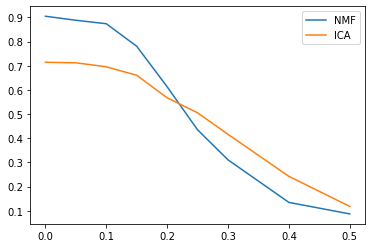

In [7]:
plt.figure(),plt.plot(sigmaTab,scoreNMF)
plt.plot(sigmaTab,scoreICA)
plt.legend(['NMF','ICA'])

# II - Clustering: K-means

We will now work on the K-means algorithm. First, the K-means algorithm will be used to cluster the toy examples datasets of the first practical work. Then, it will be used to segment real images.

## II - 1) Toy examples

Let us first define the toy examples.

In [8]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30, random_state=None):
    
    #We might want to fix the seed for reproductible results
    if random_state:
        np.random.seed(random_state)

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1: 
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T
        
        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T
    np.random.seed()
    return X0,X1,y

def plotResults(X0=None,X1=None,y=None,U=None,Y=None,const=1,title=''):

    X=np.concatenate((X0,X1),axis=0)
    
    N0=np.sum(y==0)
    N1=np.sum(y==1)
    
    fig=plt.figure(figsize=(17, 6))
    
    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()
    
    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')
    
    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')
    
    plt.show()
    
    
def frontiere(model, X, y, step=50):

    labels = np.unique(y)
 
    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)
   
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')
    
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1') 
    
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    

Now, create the data we will use.

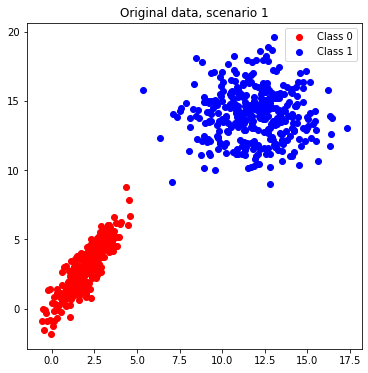

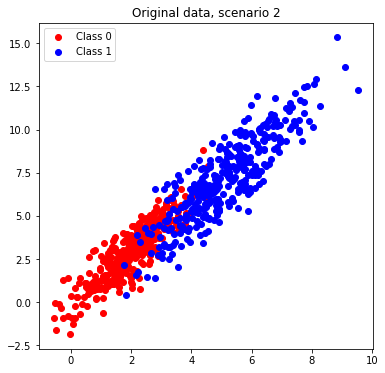

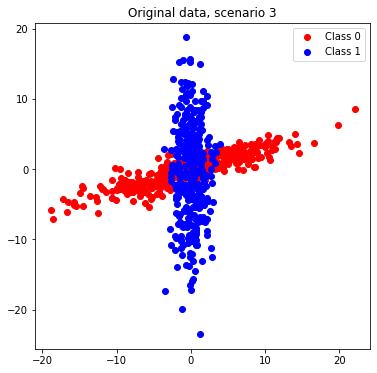

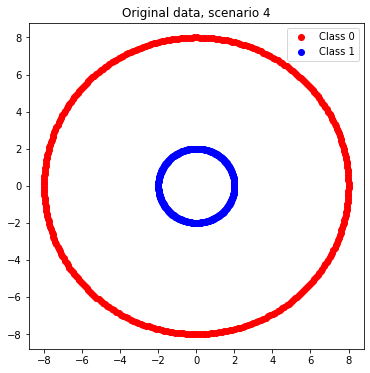

In [9]:
## Choose the scenarioIndex (value between 1 and 4)
for scenarioIndex in range(1, 5):
    ##

    X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350, random_state=10)
    X=np.concatenate((X0,X1),axis=0)

    plt.figure(figsize=(6, 6))
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    plt.title(f'Original data, scenario {scenarioIndex}')
    plt.legend()
    plt.show()

Use the K-means to find the different clusters in the dataset. K-means will be used on X and we will check whether it can well separate the two classes. 


**Question:**
1. Does it work well in all scenarios ? Why ? Is it always easy to define the correct number of clusters ?

**Answer**

It definitely not works well in all scenari. For the first one though, as the clusters are well separatable using linear projection, the K-means clustering works fine. However, for all the overlapping sources ones, it is impossible for the algorithm to correctly find the clusters. The scenario of the concentric sources is actually the toughest one because even if the sources are separated and seem to be recognizable, as they have the same center, K-mean algorithm fails.

Sometimes it can be hard to choose the correct number of clusters, for example when we have some cluster sources that are not far from each other, almost overlapping. In this type of scenario, one might not understand the real number of cluster and can mistaken different smalls clusters as one bigger.

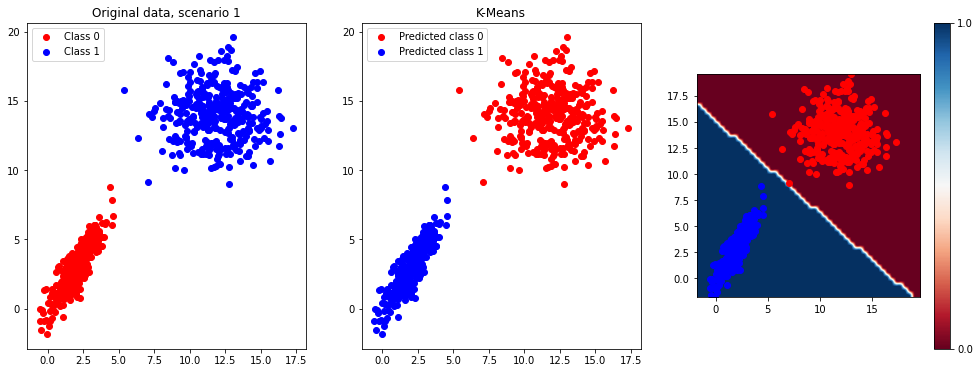

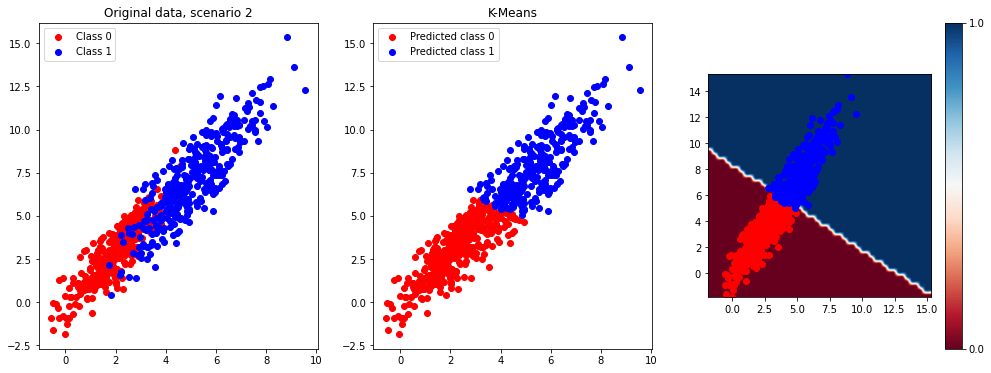

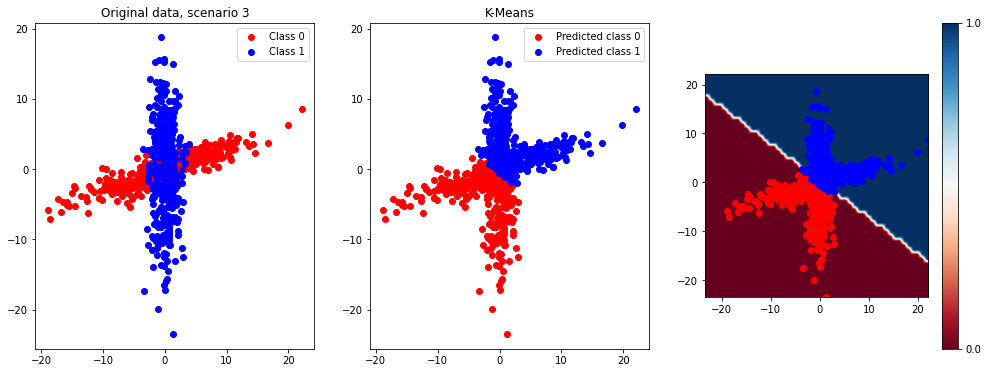

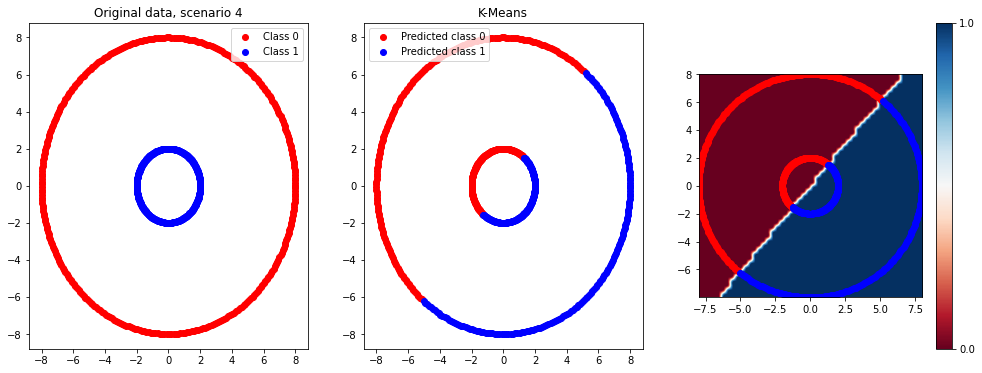

In [10]:
Nclusters = [2, 2, 2, 2] # choose a number of clusters for each scenario
for scenarioIndex in range(1, 5):
    ##

    X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350, random_state=10)
    X=np.concatenate((X0,X1),axis=0)

    ## K-means
    Ncluster= Nclusters[scenarioIndex - 1] # choose a number of clusters
    kmeans=KMeans(n_clusters=Ncluster) 
    yKmeans=kmeans.fit_predict(X)

    plt.figure(figsize=(17, 6))
    plt.subplot(131)
    plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
    plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
    plt.title(f'Original data, scenario {scenarioIndex}')
    plt.legend()

    plt.subplot(132)
    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
    plt.title('K-Means')
    plt.legend()

    plt.subplot(133)
    frontiere(kmeans, X, y, step=50)

    plt.show()

Now, implement your own K-means using the Lloyd's algorithm.

In [11]:
def KMeansLecture(X, K=2, tol=1e-4, random_state=None):
    '''
    K-means clustering using Lloyd's algorithm
    
    X: Original data
    K: Number of clusters >0
    tol: Desired tolerance to define new cluster
    random_state: fixing the seed for reproducible results
    '''
    
    if random_state:
        np.random.seed(random_state)
    
    # Random initialization
    n_samples, n_features = X.shape
    muTab = X[np.random.choice(n_samples, K, replace=False)]
    
    # Computation
    old_muTab = np.zeros_like(muTab)
    while np.linalg.norm(muTab - old_muTab) > tol:
        old_muTab = muTab.copy()
        # Assign each data point to the closest centroid
        distances = np.sqrt(((X - muTab[:, np.newaxis])**2).sum(axis=2))
        yKmeans = np.argmin(distances, axis=0)
        # Update the centroid location based on the mean of the assigned points
        for k in range(K):
            muTab[k] = np.mean(X[yKmeans == k], axis=0)
    np.random.seed()
    return yKmeans, muTab

Now, test your K-means algorithm.

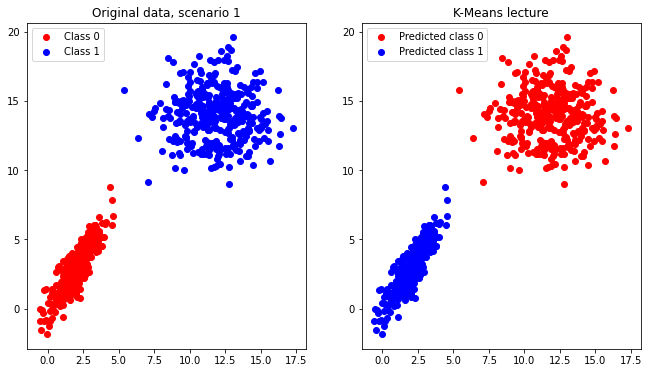

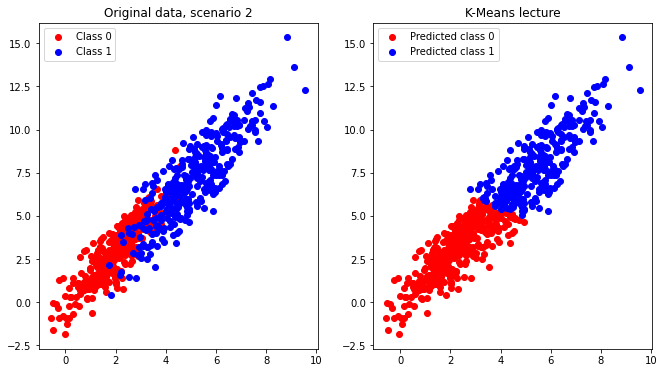

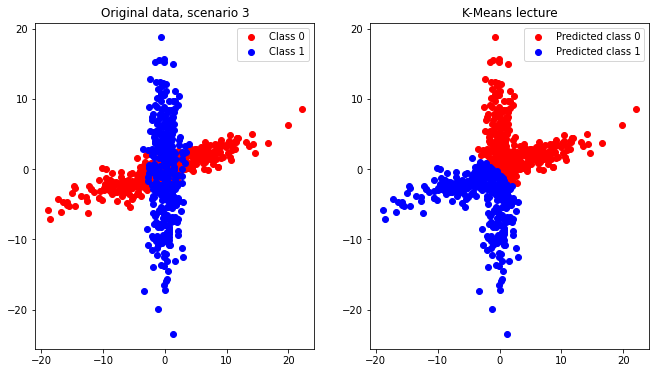

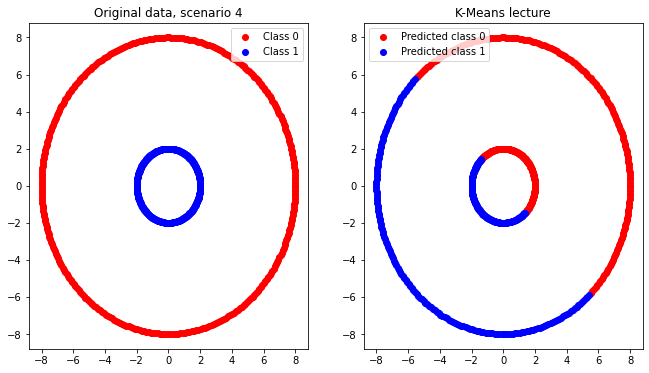

In [12]:
for scenarioIndex in range(1, 5):
    
    X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350, random_state=10)
    X=np.concatenate((X0,X1),axis=0)
    
    ## K-means
    Ncluster= 2 # choose a number of clusters
    yKmeans,muTab = KMeansLecture(X,K=Ncluster,tol=1e-4, random_state=1)

    plt.figure(figsize=(17, 6))
    plt.subplot(131)
    plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
    plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
    plt.title(f'Original data, scenario {scenarioIndex}')
    plt.legend()

    plt.subplot(132)
    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
    plt.title('K-Means lecture')
    plt.legend()

    plt.show()

## II-2) K-means for skin lesion segmentation


In this section, you will use the K-means to segment skin lesion images. You will use two images from the ISIC dataset (www.isic-archive.com), one nevus and one melanoma with their respetive manual segmentation. 

**Goal**

The goal of this section is to delineate the contours (i.e. segment) of the skin lesions using k-means. 

Let's first load the data. The images are rescaled so that the computations are faster.

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


(-0.5, 374.5, 280.5, -0.5)

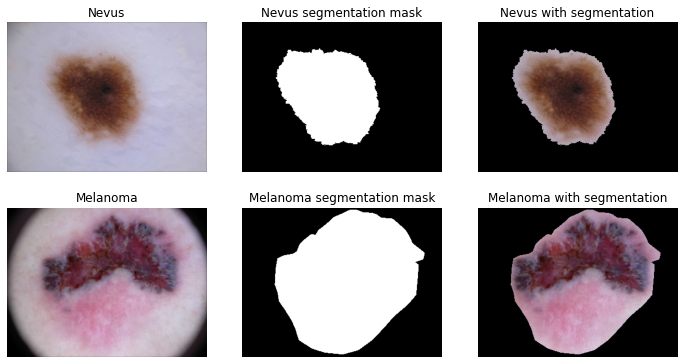

In [13]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
  dest_path='./data/nevus.jpg')
  gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
  dest_path='./data/nevus-seg.jpg')
  gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
  dest_path='./data/melanoma.jpg')
  gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
  dest_path='./data/melanoma-seg.png')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory=os.getcwd().replace('\\','/')+"/"



# Nevus
nevus = imread(Working_directory + 'nevus.jpg')
nevus=nevus[2:-2,2:-2,:] # remove border (it contains artifacts)
nevusMask = imread(Working_directory + 'nevus-seg.jpg')
nevusMask=nevusMask[2:-2,2:-2] # remove border (it contains artifacts)
# We rescale to speed up computations
nevus = rescale(nevus, 0.25,multichannel=True, anti_aliasing=True)
# We need all these options to preserve the binary values
nevusMask = rescale(nevusMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
nevusMask_boolean = (nevusMask/255).astype(np.uint8) # To get uint8
nevusMask_expand = np.expand_dims(nevusMask_boolean, axis=2) # To have a 3 channels boolean mask

# Melanoma
melanoma = imread(Working_directory + 'melanoma.jpeg')
melanoma=melanoma[2:-2,2:-2,:] # remove border (it contains artifacts)
melanomaMask = imread(Working_directory + 'melanoma-seg.png')
melanomaMask=melanomaMask[2:-2,2:-2] # remove border (it contains artifacts)
melanoma = rescale(melanoma, 0.25,multichannel=True, anti_aliasing=True)
melanomaMask = rescale(melanomaMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
melanomaMask_boolean = (melanomaMask/255).astype(np.uint8) 
melanomaMask_expand = np.expand_dims(melanomaMask_boolean, axis=2)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(nevus)
grid[0].set_title('Nevus')
grid[0].axis('off')
grid[1].imshow(nevusMask_boolean,cmap='gray')
grid[1].set_title('Nevus segmentation mask')
grid[1].axis('off')
grid[2].imshow(nevusMask_expand*nevus)
grid[2].set_title('Nevus with segmentation')
grid[2].axis('off')
grid[3].imshow(melanoma)
grid[3].set_title('Melanoma')
grid[3].axis('off')
grid[4].imshow(melanomaMask_boolean,cmap='gray')
grid[4].set_title('Melanoma segmentation mask')
grid[4].axis('off')
grid[5].imshow(melanomaMask_expand*melanoma)
grid[5].set_title('Melanoma with segmentation')
grid[5].axis('off')



**Questions**

1. Before running K-means, please answer this question. How many classes $K$ should you look for ? Would you use the same $K$ for both images ? Why ?

2. Run the following code for both images. Try to choose different channels (among the channels Red, Green and Blue) and different number of clusters $K$. Which is the best choice in terms of channel and number of classes ? You can use the [Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to quantitatively compare your mask and the manual segmentation. Comment the results with respect to the previous answer.

The dice score (or dice similarity) between two binary masks is defined as $\frac{2TP}{2TP + FP + FN}$ and it ranges between 0 (completely different) and 1 (perfectly equal).

3. Propose a way to automatically select the class (or unions of classes) representing the skin lesion and not the skin. (You don't need to implement it, just explain how you would do it).

4. In K-means, we recompute the average at each iteration. The average is not constrained to be one of the original observations. It is usually an *interpolation* of the original observations. How would you change the Lloyd's algorithm to constrain the average to always be one of the original observations ?

**Answers**

1. Ideally, we should look for 2 classes : one for lesion and one for healthy skin. The problem is that this is not always possible, as lesion skin can be of different colors. Here, for the `nevus.jpg`, the lesion consist of dark brown skin only and we might use only 2 clusters. However, in `melanoma.jpeg`, the lesion consists of 2 or 3 shades of red and darker red (maybe even black or very dark red).
2. * For `nevus.jpg`, even if with 2 clusters the result seemed good, we can largely improve it if we choose to do 5 clusters over the blue channel and select the 3 darkest of it. That gives us more than $90\%$ of dice score! 
   * For `melanoma.jpeg`, we manage to have a $74\%$ dice score clustering over channel green by 4 clusters and taking the 3 darkest ones. Note that the circular shape of the photo creates a bias when clustering and taking the mask because of dark shades it puts at the corners.
3. Maybe we can considerate that there is actually a large part of healthy skin in the picture, and then by taking the median of the sorted labels (sorted by brighness), we can know the treshold for the mask when selecting the labels taken for the lesion.
4. We can use the nearest neigbour algorithm to detect the nearest real value for each centroid.

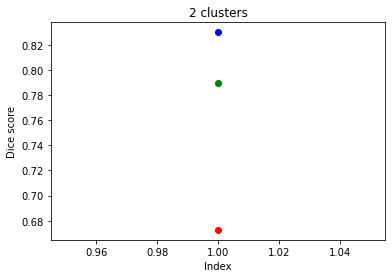

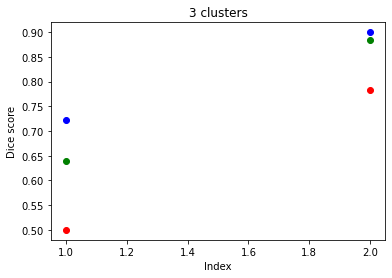

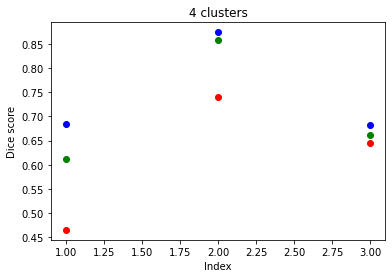

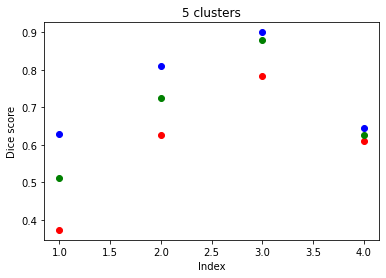

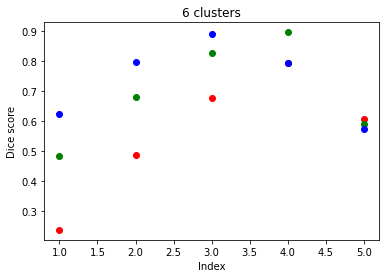

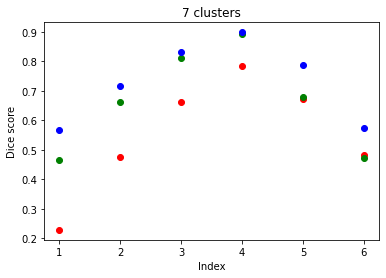

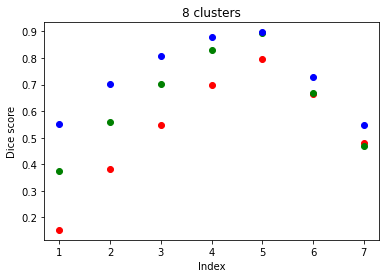

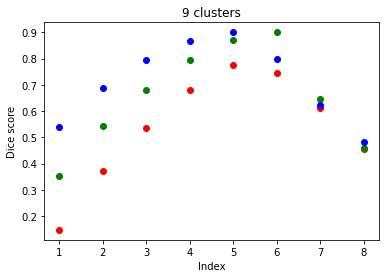

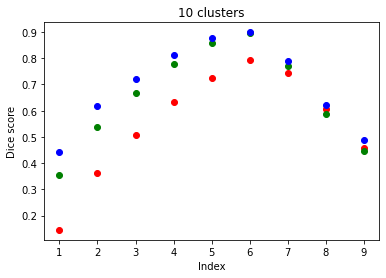

We get the best result with the channel blue, 5 clusters, selecting the 3 first ones


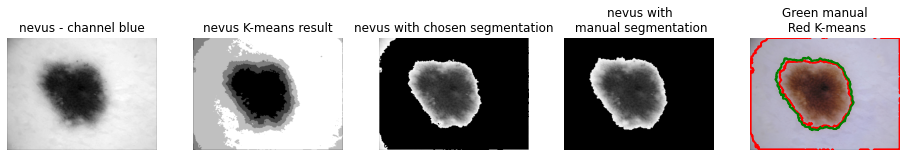

Dice score = 0.8999475962191643


In [14]:
## NEVUS

#First we need to find the best channel, number of clusters and the actual selection of clusters
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
kmax = 10 #maximum number of clusters
dice_score = np.zeros((3, kmax + 1, kmax))
colors = ['red', 'green', 'blue']
for channel in range(3):
    ##
    nevusB = nevus[:,:,channel]

    # Select the number of cluster K to look for 
    for K in range(2, kmax+1): # choose a number of clusters
        ##
        kmeans=KMeans(n_clusters=K) 
        labels=kmeans.fit_predict(nevusB.reshape(-1,1))
        labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

        # We sort the labels into new_labels in order to detect the lesion that is located in different shades (we assumed the lesion was darker)
        brightness = []
        for k in range(K):
            cluster_mask = (labels == k)
            cluster_brightness = np.mean(nevusB[cluster_mask])
            brightness.append((k, cluster_brightness))

        # Sort the clusters by brightness
        brightness_sorted = sorted(brightness, key = lambda l: l[1])

        # Assign new labels based on the sorted list
        new_labels = np.zeros_like(labels)
        for i in range(K):
            new_labels[labels == brightness_sorted[i][0]] = i

        # Depending on the number of classes K, K-means returns one integer per pixel 
        # which indicates the number of the cluster. 
        # Choose the integer to use as mask between 0 and K-1
        for index in range(1, K):
            mask=new_labels<index ## choose which labels should be considered
            score = 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1))
            dice_score[channel, K, index] = score

#displaying the results
for k in range(2, kmax+1):
    for ch in range(3):
        plt.scatter(np.arange(1, k),[dice_score[ch,k,i] for i in range(1, k)],color=colors[ch])
    plt.title(f'{k} clusters')
    plt.ylabel("Dice score")
    plt.xlabel("Index")
    plt.show()
    
#Best one
argmax = np.unravel_index(np.argmax(dice_score, axis=None), dice_score.shape)
channel_best, K_best, index_best = argmax
print(f'We get the best result with the channel {colors[channel_best]}, {K_best} clusters, selecting the {index_best} first ones')



#Now we can display the best result
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=channel_best
##
nevusB = nevus[:,:,channel]

# Select the number of cluster K to look for 
K = K_best # choose a number of clusters
##
kmeans=KMeans(n_clusters=K) 
labels=kmeans.fit_predict(nevusB.reshape(-1,1))
labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

# We sort the labels into new_labels in order to detect the lesion that is located in different shades
brightness = []
for k in range(K):
    cluster_mask = (labels == k)
    cluster_brightness = np.mean(nevusB[cluster_mask])
    brightness.append((k, cluster_brightness))

# Sort the clusters by brightness
brightness_sorted = sorted(brightness, key = lambda l: l[1])

# Assign new labels based on the sorted list
new_labels = np.zeros_like(labels)
for i in range(K):
    new_labels[labels == brightness_sorted[i][0]] = i

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1
index = index_best
mask=new_labels<index ## choose which label should be considered

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(nevusMask_boolean, 0.5)

fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(nevusB,cmap='gray')
grid[0].set_title(f'nevus - channel {colors[channel]}')
grid[0].axis('off')
grid[1].imshow(new_labels,cmap='gray')
grid[1].set_title('nevus K-means result')
grid[1].axis('off')
grid[2].imshow(mask*nevusB,cmap='gray')
grid[2].set_title('nevus with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(nevusMask_boolean*nevusB,cmap='gray')
grid[3].set_title('nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')
plt.show()
score = 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1))
print(f'Dice score = {score}')

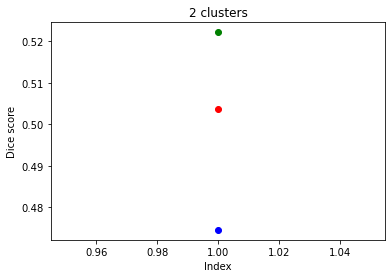

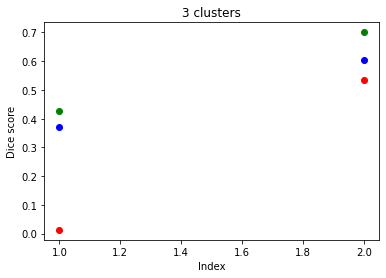

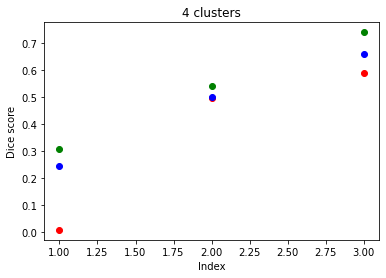

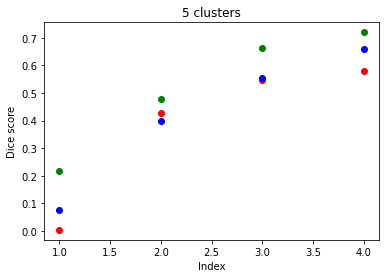

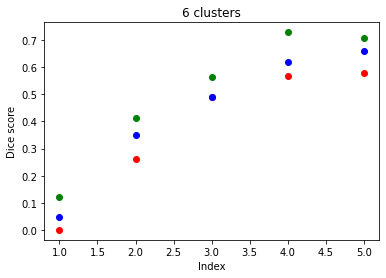

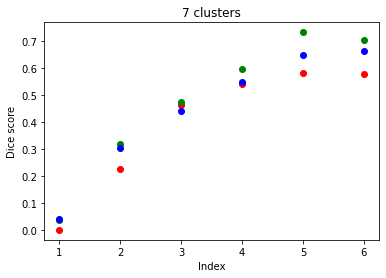

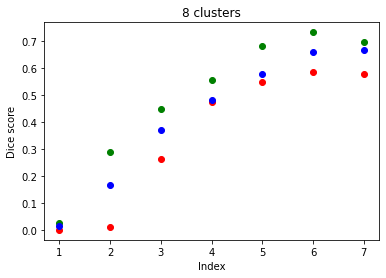

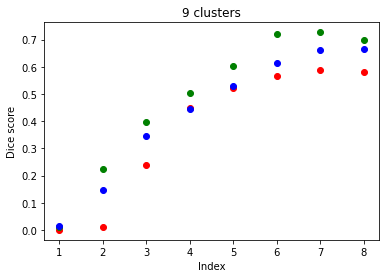

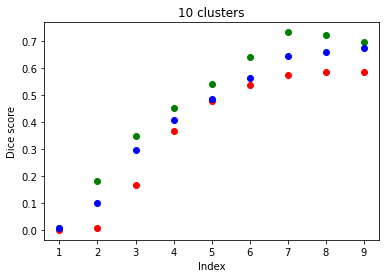

We get the best result with the channel green, 4 clusters, selecting the 3 first ones


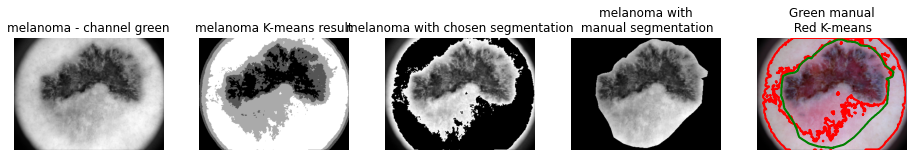

Dice score = 0.7389252470471671


In [15]:
## MELANOMA

#First we need to find the best channel, number of clusters and the actual selection of clusters
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
kmax = 10 #maximum number of clusters
dice_score = np.zeros((3, kmax + 1, kmax))
colors = ['red', 'green', 'blue']
for channel in range(3):
    ##
    melanomaB = melanoma[:,:,channel]

    # Select the number of cluster K to look for 
    for K in range(2, kmax+1): # choose a number of clusters
        ##
        kmeans=KMeans(n_clusters=K) 
        labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
        labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

        # We sort the labels into new_labels in order to detect the lesion that is located in different shades (we assumed the lesion was darker)
        brightness = []
        for k in range(K):
            cluster_mask = (labels == k)
            cluster_brightness = np.mean(melanomaB[cluster_mask])
            brightness.append((k, cluster_brightness))

        # Sort the clusters by brightness
        brightness_sorted = sorted(brightness, key = lambda l: l[1])

        # Assign new labels based on the sorted list
        new_labels = np.zeros_like(labels)
        for i in range(K):
            new_labels[labels == brightness_sorted[i][0]] = i

        # Depending on the number of classes K, K-means returns one integer per pixel 
        # which indicates the number of the cluster. 
        # Choose the integer to use as mask between 0 and K-1
        for index in range(1, K):
            mask=new_labels<index ## choose which labels should be considered
            score = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
            dice_score[channel, K, index] = score

#displaying the results
for k in range(2, kmax+1):
    for ch in range(3):
        plt.scatter(np.arange(1, k),[dice_score[ch,k,i] for i in range(1, k)],color=colors[ch])
    plt.title(f'{k} clusters')
    plt.ylabel("Dice score")
    plt.xlabel("Index")
    plt.show()
    
#Best one
argmax = np.unravel_index(np.argmax(dice_score, axis=None), dice_score.shape)
channel_best, K_best, index_best = argmax
print(f'We get the best result with the channel {colors[channel_best]}, {K_best} clusters, selecting the {index_best} first ones')



#Now we can display the best result
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=channel_best
##
melanomaB = melanoma[:,:,channel]

# Select the number of cluster K to look for 
K = K_best # choose a number of clusters
##
kmeans=KMeans(n_clusters=K) 
labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

# We sort the labels into new_labels in order to detect the lesion that is located in different shades
brightness = []
for k in range(K):
    cluster_mask = (labels == k)
    cluster_brightness = np.mean(melanomaB[cluster_mask])
    brightness.append((k, cluster_brightness))

# Sort the clusters by brightness
brightness_sorted = sorted(brightness, key = lambda l: l[1])

# Assign new labels based on the sorted list
new_labels = np.zeros_like(labels)
for i in range(K):
    new_labels[labels == brightness_sorted[i][0]] = i

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1
index = index_best
mask=new_labels<index ## choose which label should be considered

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(melanomaMask_boolean, 0.5)

fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanomaB,cmap='gray')
grid[0].set_title(f'melanoma - channel {colors[channel]}')
grid[0].axis('off')
grid[1].imshow(new_labels,cmap='gray')
grid[1].set_title('melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(mask*melanomaB,cmap='gray')
grid[2].set_title('melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')
plt.show()
score = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
print(f'Dice score = {score}')